## Ejemplo de clasificación de los jugadores de la NBA en grupos según sus estadísticas medias de su carrera.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# imports necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
import math
import random 
from urllib.request import urlopen
from bs4 import BeautifulSoup

import re
import glob

import seaborn as sns
sns.set_style("whitegrid")

from IPython.core.display import display, HTML

import sklearn as skl
from sklearn import cluster, metrics, datasets
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
# funciones necesarias
np.set_printoptions(precision=4)
# datos para Kmeans
LOOPS = 25
MAX_ITERATIONS = 50
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 20

# función para graficar el valor de la inercia según el número de clusters en los que se separen los datos
def plot_results(inertials):
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.show()


# función para calcular la inercia según el número de clusters
def select_clusters(points, loops, max_iterations, init_cluster, tolerance,
                    num_threads):
    
    inertia_clusters = list()

    for i in range(1, loops + 1, 1):
        # Creamos el objeto Kmeans
        kmeans = KMeans(n_clusters=i, max_iter=max_iterations,
                        init=init_cluster, tol=tolerance, n_jobs=num_threads)

        # Calculamos Kmeans
        kmeans.fit(points)

        # Obtenemos la inercia
        inertia_clusters.append([i, kmeans.inertia_])

    plot_results(inertia_clusters)


# función para dibujar el dendograma que sería otra técnica para seleccionar el número de clusters para KMeans
def plot_dendrogram(points):
    # calcula la distancia entre puntos o grupos de puntos
    Z = linkage(points, metric='euclidean', method='ward')

    plt.title('Dendrogram')
    plt.xlabel('Points')
    plt.ylabel('Euclidean Distance')

    # genera el dendograma
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=30,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True
    )

    plt.show()


# función que grafica la distancia euclidea según el número de clusters
def plot_gap(points):    
    # Calculamos las distancias entre los puntos
    Z = linkage(points, metric='euclidean', method='ward')

    # Nos quedamos con las últimas 10 distancias. Las distancias están en la columna 2 (tercera columna) de Z
    last = Z[-20:, 2]
    
    num_clusters = np.arange(1, len(last) + 1)

    # Determinados el Gap
    gap = np.diff(last, n=2)
    plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
    plt.show()


# función para aplicar KMeans pasándole los datos y el número de clusters
def kmeans(reduced_data, n_clusters):
    #kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++', max_iter=MAX_ITERATIONS, random_state=42)
    kmeans = kmeans.fit(reduced_data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    sil_score = metrics.silhouette_score(reduced_data, kmeans.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }

    return data_dictionary


# función para encontrar el mejor dato de silhouette score
def find_best_cluster(data,a,b):
    scores = []
    for i in range(a,b):
        i_clusters = kmeans(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Silhouette Score to Find Best Cluster""")
    print("Best silhouette score:", np.max(scores))


# función que devuelve la lista de atributos ordenados según su importancia
def feature_importance(cluster_data, league_data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(zip(cluster_data.columns, pca.components_[0], np.mean(cluster_data),\
            np.mean(league_data)), columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).\
            sort_values('Importance', ascending=False)

    return features


# función para graficar los clusters formados con los datos
def plot_kmeans_cluster(reduced_data, k_clusters, plot_title):
    kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=10)
    kmeans.fit(reduced_data)

    h = .02
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(15,10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
    # mostrar los centroides de cada cluster con una x
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title(plot_title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

#### Preparación de los datos.

In [4]:
# cargar dataframe con los estadísticas simples de todos los jugadores de la historia de la NBA
df_nba_game = pd.read_csv('./NBA_game.csv', sep=',')
print("Dataset NBA per game: num_rows: %d\tColumnas: %d\n" % (df_nba_game.shape[0], df_nba_game.shape[1]))
print("columns:\n", list(df_nba_game.columns))

Dataset NBA per game: num_rows: 27069	Columnas: 30

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year']


In [5]:
# visualizamos los primeros datos
df_nba_game.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,John Abramovic,F,27.0,PIT,47.0,NaN,NaN,4.3,17.7,0.242,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,3.4,11.2,1947
1,Chet Aubuchon,G,30.0,DTF,30.0,NaN,NaN,0.8,3.0,0.253,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,1.5,2.2,1947
2,Norm Baker,G,23.0,CHS,4.0,NaN,NaN,0.0,0.3,0.000,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1947
3,Herschel Baltimore,F,25.0,STB,58.0,NaN,NaN,0.9,4.5,0.202,...,NaN,NaN,NaN,0.3,NaN,NaN,NaN,1.7,2.4,1947
4,John Barr,F,28.0,STB,58.0,NaN,NaN,2.1,7.6,0.283,...,NaN,NaN,NaN,0.9,NaN,NaN,NaN,2.8,5.1,1947
5,Frankie Baumholtz,G,28.0,CLR,45.0,NaN,NaN,5.7,19.0,0.298,...,NaN,NaN,NaN,1.2,NaN,NaN,NaN,2.1,14.0,1947
6,Moe Becker,G-F,29.0,TOT,43.0,NaN,NaN,1.6,8.3,0.196,...,NaN,NaN,NaN,0.7,NaN,NaN,NaN,2.3,3.8,1947
7,Moe Becker,G-F,29.0,PIT,17.0,NaN,NaN,2.7,13.5,0.201,...,NaN,NaN,NaN,0.8,NaN,NaN,NaN,2.9,6.4,1947
8,Moe Becker,G-F,29.0,BOS,6.0,NaN,NaN,0.8,3.7,0.227,...,NaN,NaN,NaN,0.2,NaN,NaN,NaN,2.5,2.2,1947
9,Moe Becker,G-F,29.0,DTF,20.0,NaN,NaN,1.0,5.4,0.178,...,NaN,NaN,NaN,0.8,NaN,NaN,NaN,1.7,2.1,1947


In [6]:
# visualizamos los últimos datos
df_nba_game.tail(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
27059,Robert Williams,C,22.0,BOS,5.0,1.0,15.0,2.2,3.2,0.688,...,1.4,3.4,4.8,2.2,1.2,1.2,0.6,3.2,4.6,2020
27060,Nigel Williams-Goss,PG,25.0,UTA,3.0,0.0,2.3,0.0,0.3,0.000,...,0.0,0.0,0.0,0.3,0.0,0.0,0.3,0.3,0.0,2020
27061,D.J. Wilson,PF,23.0,MIL,3.0,0.0,4.7,0.7,2.3,0.286,...,0.0,1.3,1.3,0.7,0.0,0.0,0.3,0.3,1.7,2020
27062,Justise Winslow,SF,23.0,MIA,5.0,5.0,36.2,5.6,14.4,0.389,...,1.8,6.2,8.0,4.8,1.0,0.6,3.2,3.4,13.8,2020
27063,Christian Wood,PF,24.0,DET,8.0,0.0,15.1,3.1,5.0,0.625,...,1.0,3.3,4.3,0.3,0.1,0.9,1.0,0.6,8.8,2020
27064,Delon Wright,SG,27.0,DAL,7.0,2.0,23.7,3.6,6.1,0.581,...,0.3,2.7,3.0,3.9,1.4,0.0,0.6,1.4,9.3,2020
27065,Thaddeus Young,PF,31.0,CHI,9.0,0.0,21.9,4.2,9.0,0.469,...,0.8,2.8,3.6,1.4,1.2,0.3,1.4,1.8,9.9,2020
27066,Trae Young,PG,21.0,ATL,6.0,6.0,29.7,8.2,17.7,0.462,...,0.3,3.8,4.2,7.5,1.0,0.0,4.5,1.2,24.2,2020
27067,Cody Zeller,C,27.0,CHO,6.0,6.0,27.0,5.0,10.0,0.500,...,4.0,6.5,10.5,1.5,0.5,0.5,1.5,2.3,12.8,2020
27068,Ivica Zubac,C,22.0,LAC,8.0,7.0,15.6,3.1,4.4,0.714,...,1.6,4.4,6.0,0.5,0.1,1.4,1.0,2.1,8.9,2020


In [7]:
# generamos un dataframe solo con los jugadores y su posición
df_player_pos = df_nba_game[['Player', 'Pos']]
# eliminamos los jugadores repetidos
df_player_pos.drop_duplicates('Player', keep="first", inplace=True)
# ordenamos por la columna de jugadores
df_player_pos = df_player_pos.sort_values(by=['Player'])
# mostrar el tamaño del dataframe
df_player_pos.shape

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(4393, 2)

In [8]:
df_player_pos.tail(10)

,Player,Pos
24686,Álex Abrines,SG
26114,Ángel Delgado,C
16565,Óscar Torres,SG
21132,Ömer Aşık,C
18523,Šarūnas Jasikevičius,PG
10416,Šarūnas Marčiulionis*,SG
12845,Žan Tabak,C
10463,Žarko Paspalj,SF
17185,Žarko Čabarkapa,PF
16489,Željko Rebrača,C


In [9]:
# añadimos al dataframe general una columna con valor 1 por jugador, y luego poder sumarlas por cada jugador para
# poder agrupar sus estadísticas de cada temporada y dividir por ese número y así tener la media de cada atributo.
def f_player(row):
    return 1
    print(row)
    
# añadimos la columna sumando 1 a cada jugador
df_nba_game['Player_num'] = df_nba_game.apply(f_player, axis=1)

In [10]:
# agrupamos el dataframe por jugador, y sumamos todos los valores para tener el total de cada atributo por jugador 
df_players = df_nba_game.groupby(('Player')).sum()
df_players.shape

(4393, 28)

In [11]:
df_players.tail(10)

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Player_num
Player,,,,,,,,,,,,,,,,,,,,,
Álex Abrines,72.0,174.0,16.0,49.6,5.3,14.0,1.145,3.8,10.6,1.084,...,3.6,4.3,1.6,1.5,0.4,1.3,5.1,16.0,6054,3
Ángel Delgado,24.0,2.0,0.0,7.5,0.5,2.5,0.200,0.0,0.0,0.000,...,1.0,2.0,0.0,0.5,0.0,0.0,1.0,1.5,2019,1
Óscar Torres,51.0,82.0,13.0,22.9,3.0,7.3,0.840,1.0,2.7,0.832,...,1.7,2.6,0.8,0.6,0.2,1.3,1.5,9.1,4005,2
Ömer Aşık,282.0,489.0,262.0,169.9,15.1,29.8,4.839,0.0,0.0,0.000,...,40.7,57.5,4.7,3.0,5.7,9.7,17.2,39.3,20152,10
Šarūnas Jasikevičius,119.0,201.0,21.0,66.0,8.2,20.7,1.572,3.2,9.2,1.347,...,4.3,5.2,11.0,1.8,0.1,5.7,4.8,25.1,8027,4
Šarūnas Marčiulionis*,199.0,363.0,30.0,152.3,29.1,58.4,3.402,2.5,7.3,2.100,...,9.9,15.7,15.6,8.6,0.6,14.2,18.4,86.2,13954,7
Žan Tabak,215.0,304.0,104.0,111.5,16.1,33.2,3.851,0.0,0.0,0.000,...,16.1,26.6,5.3,2.5,4.5,8.3,18.2,37.3,15983,8
Žarko Paspalj,23.0,28.0,1.0,6.5,1.0,2.8,0.342,0.0,0.0,0.000,...,0.5,1.1,0.4,0.1,0.3,0.8,1.3,2.6,1990,1
Žarko Čabarkapa,115.0,190.0,4.0,48.0,8.5,18.2,2.335,0.9,2.9,1.160,...,6.5,10.1,2.4,1.0,0.6,3.3,6.0,22.6,10025,5


In [12]:
# se divide cada valor total por el número de apariciones y se obtiene la media por jugador para cada atributo
df_aux = df_players.div(df_players['Player_num'], axis=0).round(2)
df_aux.shape

(4393, 28)

In [13]:
# eliminamos del dataframe las columnas que no son necesarias
df_aux = df_aux.drop(columns=['Player_num', 'Age', 'Year'], axis=1)

In [14]:
df_aux.tail(10)

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Álex Abrines,58.00,5.33,16.53,1.77,4.67,0.38,1.27,3.53,0.36,0.50,...,0.89,0.27,1.20,1.43,0.53,0.50,0.13,0.43,1.70,5.33
Ángel Delgado,2.00,0.00,7.50,0.50,2.50,0.20,0.00,0.00,0.00,0.50,...,0.50,1.00,1.00,2.00,0.00,0.50,0.00,0.00,1.00,1.50
Óscar Torres,41.00,6.50,11.45,1.50,3.65,0.42,0.50,1.35,0.42,1.00,...,0.74,0.45,0.85,1.30,0.40,0.30,0.10,0.65,0.75,4.55
Ömer Aşık,48.90,26.20,16.99,1.51,2.98,0.48,0.00,0.00,0.00,1.51,...,0.45,1.68,4.07,5.75,0.47,0.30,0.57,0.97,1.72,3.93
Šarūnas Jasikevičius,50.25,5.25,16.50,2.05,5.18,0.39,0.80,2.30,0.34,1.25,...,0.90,0.25,1.08,1.30,2.75,0.45,0.02,1.42,1.20,6.28
Šarūnas Marčiulionis*,51.86,4.29,21.76,4.16,8.34,0.49,0.36,1.04,0.30,3.76,...,0.77,0.81,1.41,2.24,2.23,1.23,0.09,2.03,2.63,12.31
Žan Tabak,38.00,13.00,13.94,2.01,4.15,0.48,0.00,0.00,0.00,2.01,...,0.52,1.29,2.01,3.32,0.66,0.31,0.56,1.04,2.28,4.66
Žarko Paspalj,28.00,1.00,6.50,1.00,2.80,0.34,0.00,0.00,0.00,1.00,...,0.82,0.50,0.50,1.10,0.40,0.10,0.30,0.80,1.30,2.60
Žarko Čabarkapa,38.00,0.80,9.60,1.70,3.64,0.47,0.18,0.58,0.23,1.50,...,0.80,0.72,1.30,2.02,0.48,0.20,0.12,0.66,1.20,4.52


In [15]:
# comprobamos que no hay datos vacíos o nulos en el dataframe
df_aux.isnull().sum().max()

0

In [16]:
# obtenemos la lista de jugadores (sin duplicados) y su posición, y las añadimos al dataframe final que usaremos
lista_player = list(df_player_pos['Player'])
lista_pos = list(df_player_pos['Pos'])
df_aux['Player'] = lista_player
df_aux['Pos'] = lista_pos

# ordenar las columnas del dataframe para poner player en el primer lugar
df_aux = df_aux.reindex(columns=(['Player'] + list([a for a in df_aux.columns if a != 'Player']) ))

In [17]:
# en el dataframe final que utilizaremos eliminamos registros donde el jugador no tenga una media de al menos 10
# partidos jugados por temporada, y también de al menos 10 minutos por partido, y así quitamos registros de 
# jugadores que hayan jugado muy poco y tengan valores que no son realmente valiosos.
df_final = df_aux[df_aux['G']>10]
df_final = df_aux[df_aux['MP']>10]
df_final.shape

(2712, 27)

In [18]:
df_final.tail(10)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos
Player,,,,,,,,,,,,,,,,,,,,,
Zhaire Smith,Zhaire Smith,6.00,2.00,18.50,2.30,5.70,0.41,1.00,2.70,0.38,...,0.50,1.70,2.20,1.70,0.30,0.30,1.00,1.30,6.70,SG
Zoran Planinić,Zoran Planinić,49.33,3.33,10.77,1.37,3.30,0.41,0.23,0.87,0.30,...,0.33,1.03,1.33,1.10,0.43,0.07,0.83,1.60,3.83,SG
Zydrunas Ilgauskas,Zydrunas Ilgauskas,64.85,55.69,27.39,4.98,10.41,0.48,0.03,0.12,0.13,...,2.88,4.45,7.34,1.09,0.52,1.53,1.79,3.38,12.94,C
Álex Abrines,Álex Abrines,58.00,5.33,16.53,1.77,4.67,0.38,1.27,3.53,0.36,...,0.27,1.20,1.43,0.53,0.50,0.13,0.43,1.70,5.33,SG
Óscar Torres,Óscar Torres,41.00,6.50,11.45,1.50,3.65,0.42,0.50,1.35,0.42,...,0.45,0.85,1.30,0.40,0.30,0.10,0.65,0.75,4.55,SG
Ömer Aşık,Ömer Aşık,48.90,26.20,16.99,1.51,2.98,0.48,0.00,0.00,0.00,...,1.68,4.07,5.75,0.47,0.30,0.57,0.97,1.72,3.93,C
Šarūnas Jasikevičius,Šarūnas Jasikevičius,50.25,5.25,16.50,2.05,5.18,0.39,0.80,2.30,0.34,...,0.25,1.08,1.30,2.75,0.45,0.02,1.42,1.20,6.28,PG
Šarūnas Marčiulionis*,Šarūnas Marčiulionis*,51.86,4.29,21.76,4.16,8.34,0.49,0.36,1.04,0.30,...,0.81,1.41,2.24,2.23,1.23,0.09,2.03,2.63,12.31,SG
Žan Tabak,Žan Tabak,38.00,13.00,13.94,2.01,4.15,0.48,0.00,0.00,0.00,...,1.29,2.01,3.32,0.66,0.31,0.56,1.04,2.28,4.66,C


#### Preprocesamiento de datos.

In [19]:
# obtenemos de los datos la X e y, variables predict y target.
X = df_final.drop(['Player','G','Pos'], axis=1)
y = df_final['Pos']

In [20]:
# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Reducción de dimensionalidad con PCA

In [21]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.5936225724961885


#### Reducción de dimensionalidad con LDA

In [22]:
LDA = LinearDiscriminantAnalysis(n_components=2, shrinkage='auto', solver='eigen')

In [23]:
LDA_reduced_df = LDA.fit(X_scaled,y).transform(X_scaled)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/covariance/shrunk_covariance_.py:211: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/covariance/empirical_covariance_.py:76: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/covariance/shrunk_covariance_.py:211: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/covariance/empirical_covariance_.py:76: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/covariance/shrunk_co

In [24]:
LDA.score(X_scaled,y)

0.5660029498525073

#### Encontrar el mejor cluster con KMeans

Best silhouette score: 0.36424866531418837


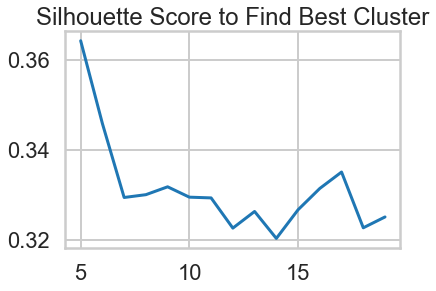

In [25]:
find_best_cluster(LDA_reduced_df,5,20)

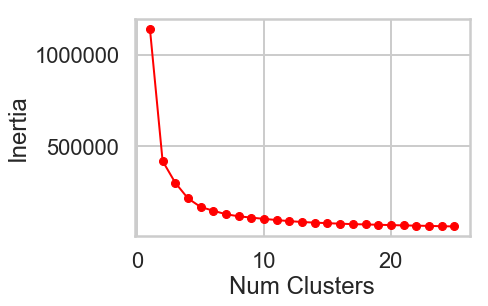

In [26]:
select_clusters(X, LOOPS, MAX_ITERATIONS, INITIALIZE_CLUSTERS, CONVERGENCE_TOLERANCE, NUM_THREADS)

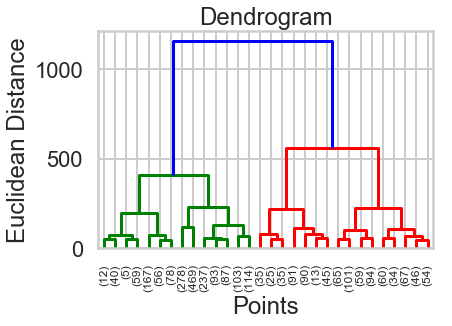

In [27]:
plot_dendrogram(X)

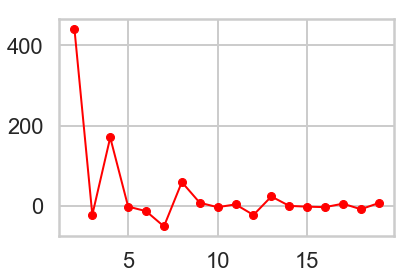

In [28]:
plot_gap(X)

#### Aunque los mejores datos se obtienen con 2 como el número de clusters, o 4, son valores muy bajos que realmente en la práctica no clasifican bien a los jugadores, ya que en la realidad hay más tipos diferentes de jugadores. Viendo el dendograma y la última gráfica se aprecia como 8 puede ser un número bueno de clusters.

In [29]:
kmeans = kmeans(LDA_reduced_df, 8)

In [30]:
# asignamos en el dataframe el label cluster elegido para cada jugador
df_final['Cluster'] = kmeans['labels']

# silhouette score
print("silhouette score:", kmeans['silhouette_score'])

silhouette score: 0.3300436150803761


/Users/josemanuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


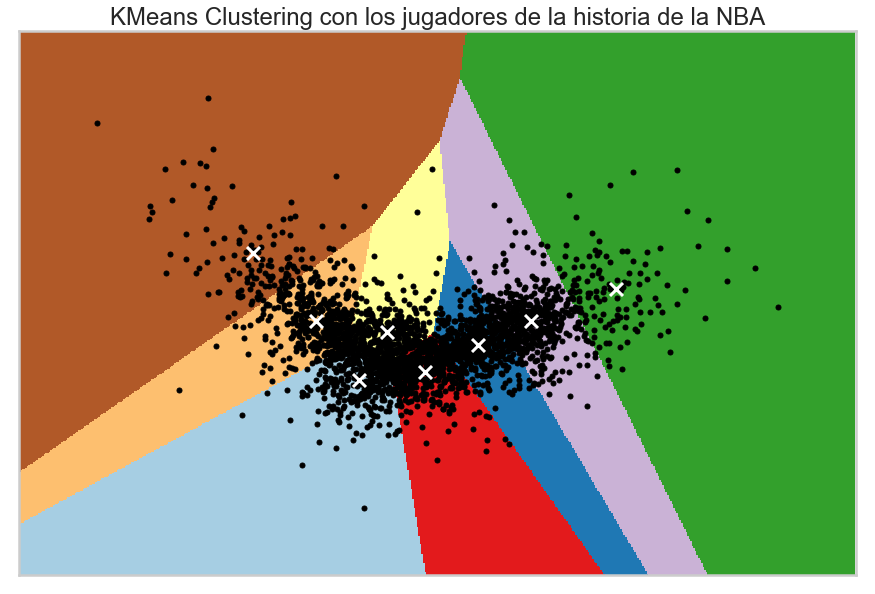

In [31]:
plot_kmeans_cluster(LDA_reduced_df, k_clusters=8,\
            plot_title="""KMeans Clustering con los jugadores de la historia de la NBA""")

In [ ]:
plot_kmeans_cluster(LDA_reduced_df, k_clusters=8,\
            plot_title="""KMeans Clustering con los jugadores de la historia de la NBA""")

#### Visualizar los cluster formados

In [32]:
df_final.tail(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
York Larese,York Larese,39.33,0.00,10.57,1.87,4.70,0.40,0.00,0.00,0.00,...,0.00,1.17,1.47,0.00,0.00,0.00,1.57,4.53,SG,4
Yuta Watanabe,Yuta Watanabe,15.00,0.00,11.60,1.00,3.40,0.29,0.10,1.10,0.12,...,1.80,2.10,0.50,0.30,0.10,0.40,0.70,2.60,SF,7
Zabian Dowdell,Zabian Dowdell,24.00,0.00,12.20,2.10,5.20,0.41,0.10,0.40,0.30,...,0.60,0.80,2.10,0.80,0.10,1.20,1.30,5.00,PG,5
Zach Collins,Zach Collins,48.67,1.33,20.70,2.40,5.30,0.45,0.67,1.87,0.36,...,2.73,3.83,1.23,0.20,0.70,1.30,2.67,6.67,C,1
Zach LaVine,Zach LaVine,50.33,35.83,30.65,6.23,14.22,0.44,1.82,4.87,0.37,...,3.13,3.73,3.53,0.93,0.28,2.45,2.30,17.30,PG,0
Zach Randolph,Zach Randolph,61.37,48.79,30.76,6.63,14.16,0.47,0.23,0.82,0.21,...,6.20,9.11,1.81,0.76,0.26,2.02,2.33,16.68,PF,6
Zaid Abdul-Aziz,Zaid Abdul-Aziz,40.71,0.00,17.61,2.76,6.93,0.40,0.00,0.00,0.00,...,1.81,6.78,0.98,0.20,0.30,0.23,2.04,7.17,C,6
Zaza Pachulia,Zaza Pachulia,68.62,32.25,20.25,2.37,5.04,0.47,0.00,0.02,0.00,...,3.60,5.74,1.32,0.70,0.34,1.30,2.48,6.70,C,6
Zeke Zawoluk,Zeke Zawoluk,59.67,0.00,19.07,2.10,5.63,0.37,0.00,0.00,0.00,...,0.00,4.00,1.17,0.00,0.00,0.00,2.43,6.43,PF,7


In [33]:
# ver el número de registros para cada valor de la clase target del cluster. Los clusters con mayor número de jugadores serían el 7, 1 y 6.
pd.value_counts(df_final['Cluster'])

7    480
1    464
6    417
5    387
0    382
4    327
2    129
3    126
Name: Cluster, dtype: int64

In [34]:
# vemos la importancia de cada atributo ordenada para uno de los clusters, en este caso el número 7.
cluster_num = (df_final['Cluster'] == 7)

cluster_data = df_final[cluster_num].drop(['Player', 'Pos', 'Cluster'], axis=1)
league_data = df_final.drop(['Player', 'Pos', 'Cluster'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PTS,0.277912,7.407750,7.906158
1,FG,0.274605,2.819104,3.023503
2,MP,0.268031,18.274625,19.654373
3,FGA,0.266071,6.567854,6.888861
4,AST,0.253431,1.082042,1.809952
5,2P,0.249849,2.398771,2.693901
6,TRB,0.238687,3.085417,3.549738
7,FT,0.233298,1.350458,1.531656
8,2PA,0.231278,5.319771,5.911770
9,FTA,0.228423,1.814542,2.088429


/Users/josemanuel/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


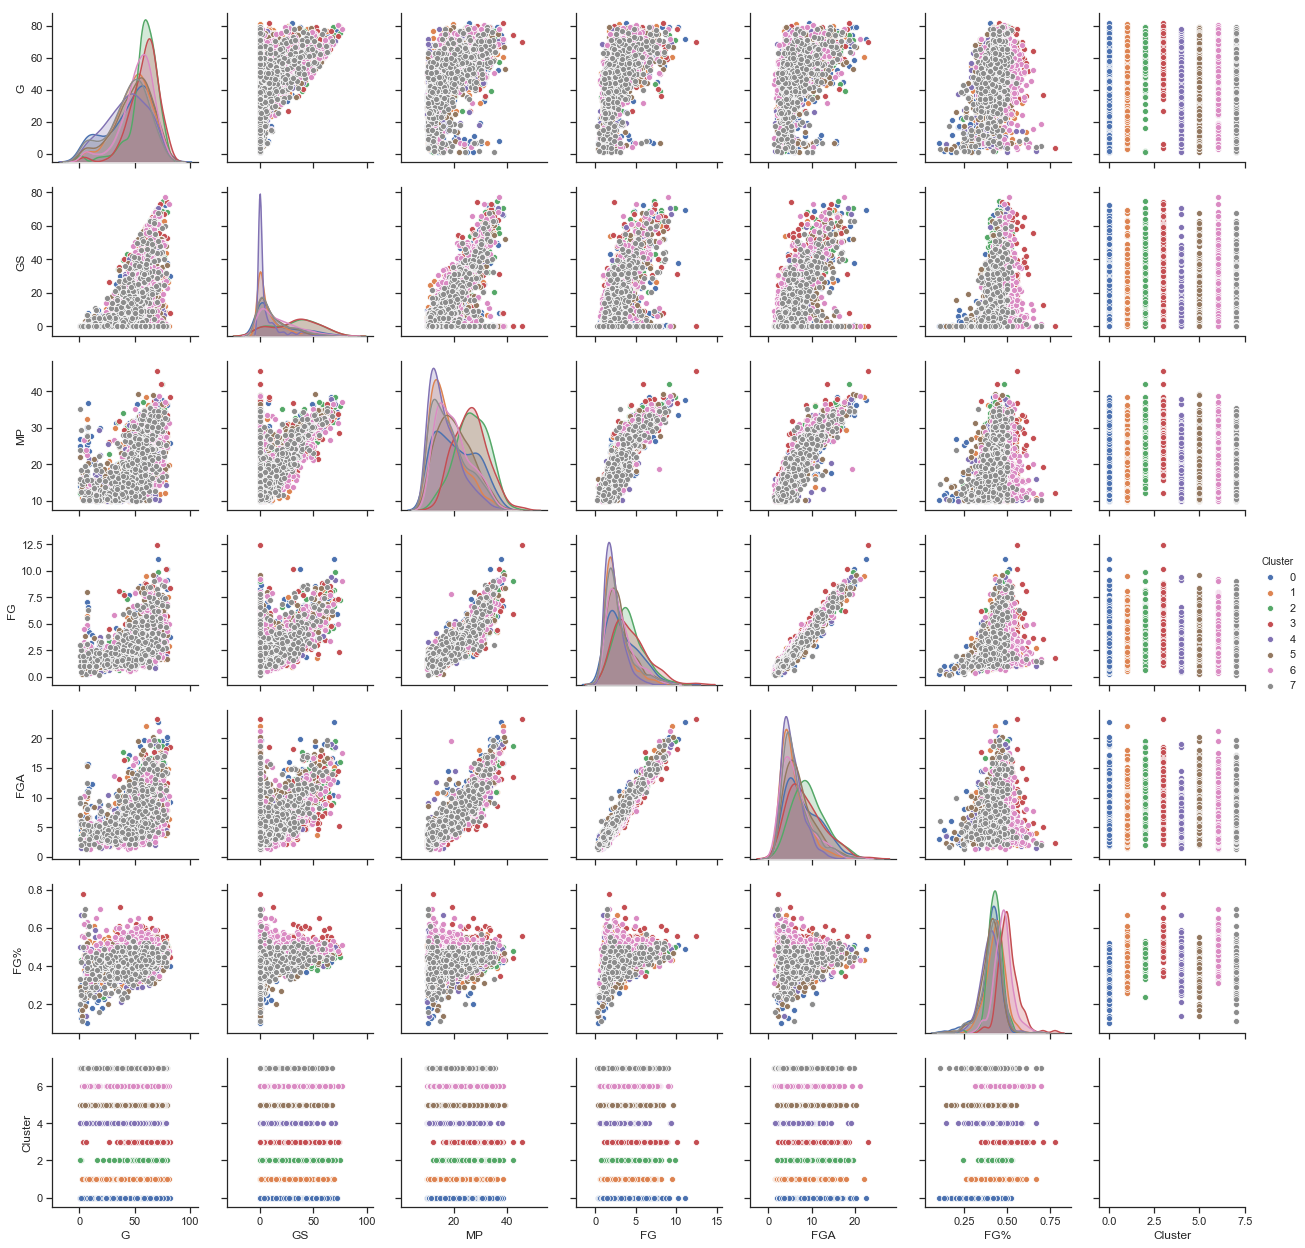

In [35]:
# graficamos los datos del dataset donde se aprecia cada cluster con un color diferente. Visualizamos los primeros atributos por cuestión de espacio.
display(HTML("<style>.container { width:100% !important; }</style>"));

sns.set(style="ticks")

vars_uno = df_final.columns[ : 7]
target_nba = df_final.columns[-1]

sns.pairplot( df_final[ list(vars_uno) + [target_nba] ], hue="Cluster" )

In [36]:
# dataframe con los registros del cluster 0. Describe para primer análisis de estos registros.
df_final_0 = df_final[df_final['Cluster']==0]
df_final_0.describe().T

,count,mean,std,min,25%,50%,75%,max
G,382.0,45.404869,19.975245,1.00,33.1250,50.520,60.7050,82.00
GS,382.0,15.027173,18.813550,0.00,0.0000,6.550,25.2400,72.44
MP,382.0,20.909607,7.590976,10.03,14.1175,19.940,27.3950,38.45
FG,382.0,3.455079,1.965889,0.30,1.9400,2.920,4.8000,11.09
FGA,382.0,8.157723,4.077400,1.90,4.9775,7.195,11.0675,22.70
FG%,382.0,0.400628,0.064431,0.10,0.3800,0.410,0.4400,0.52
3P,382.0,0.658455,0.604582,0.00,0.1000,0.510,1.1000,2.91
3PA,382.0,1.896518,1.604018,0.00,0.3200,1.700,3.1350,6.93
3P%,382.0,0.252906,0.146144,0.00,0.1700,0.310,0.3600,1.00
2P,382.0,2.796571,1.922770,0.20,1.3025,2.280,3.9600,10.57


In [49]:
# agrupamos datos por Cluster para analizar la media de cada atributo por cluster
df_group = df_final.groupby(['Cluster']).mean()
df_group.T

Cluster,0,1,2,3,4,5,6,7
G,45.404869,49.017780,58.456124,58.912143,43.500642,48.618734,52.506835,44.620625
GS,15.027173,9.283987,33.228372,33.517619,6.221101,12.771085,17.096906,12.741604
MP,20.909607,17.521616,26.771860,26.324683,16.582324,20.466486,19.903861,18.274625
FG,3.455079,2.628556,4.138915,4.376270,2.341193,3.021525,3.085971,2.819104
FGA,8.157723,5.973621,9.436047,8.648571,5.666239,7.208269,6.457026,6.567854
FG%,0.400628,0.433427,0.429612,0.506587,0.405382,0.402584,0.476787,0.411667
3P,0.658455,0.137866,0.650775,0.084286,0.212875,0.480207,0.061583,0.420500
3PA,1.896518,0.420927,1.885736,0.261587,0.651774,1.437003,0.204053,1.248396
3P%,0.252906,0.104052,0.243178,0.080238,0.138043,0.228630,0.068082,0.208437
2P,2.796571,2.489763,3.487519,4.290317,2.126972,2.542946,3.023501,2.398771


In [37]:
# generamos el dataframe para cada cluster, y otros con los jugadores por cluster ordenados por media de puntos.
df_final_0 = df_final[df_final['Cluster']==0]
df_final_1 = df_final[df_final['Cluster']==1]
df_final_2 = df_final[df_final['Cluster']==2]
df_final_3 = df_final[df_final['Cluster']==3]
df_final_4 = df_final[df_final['Cluster']==4]
df_final_5 = df_final[df_final['Cluster']==5]
df_final_6 = df_final[df_final['Cluster']==6]
df_final_7 = df_final[df_final['Cluster']==7]

df_best_0 = df_final_0.sort_values(by=['PTS'], ascending=False)
df_best_1 = df_final_1.sort_values(by=['PTS'], ascending=False)
df_best_2 = df_final_2.sort_values(by=['PTS'], ascending=False)
df_best_3 = df_final_3.sort_values(by=['PTS'], ascending=False)
df_best_4 = df_final_4.sort_values(by=['PTS'], ascending=False)
df_best_5 = df_final_5.sort_values(by=['PTS'], ascending=False)
df_best_6 = df_final_6.sort_values(by=['PTS'], ascending=False)
df_best_7 = df_final_7.sort_values(by=['PTS'], ascending=False)

In [38]:
# visualizamos los 20 jugadores por cluster con mayor media de puntos
df_best_0.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Michael Jordan*,Michael Jordan*,71.47,69.27,37.58,11.09,22.70,0.49,0.54,1.62,0.28,...,4.59,6.12,5.14,2.29,0.83,2.69,2.59,29.45,SG,0
George Gervin*,George Gervin*,79.10,37.70,33.54,10.17,19.92,0.51,0.09,0.32,0.18,...,3.06,4.55,2.81,1.18,0.85,2.73,2.95,26.19,SF,0
Kobe Bryant,Kobe Bryant,67.30,59.90,35.77,8.45,19.04,0.44,1.30,4.06,0.32,...,4.12,5.20,4.76,1.41,0.46,3.13,2.44,24.20,SG,0
Donovan Mitchell,Donovan Mitchell,54.67,52.00,33.73,8.53,18.63,0.46,2.13,5.87,0.37,...,3.30,4.20,3.93,1.60,0.27,2.43,2.77,23.27,SG,0
Rick Barry*,Rick Barry*,79.40,0.00,36.20,9.11,20.27,0.45,0.10,0.31,0.03,...,2.98,6.49,5.05,1.39,0.33,0.73,2.85,23.07,SF,0
Pete Maravich*,Pete Maravich*,58.42,0.67,34.37,8.71,19.76,0.44,0.06,0.09,0.17,...,2.05,3.66,4.78,0.88,0.18,1.25,2.59,22.22,SG,0
Geoff Petrie,Geoff Petrie,74.33,0.00,37.57,8.85,19.48,0.45,0.00,0.00,0.00,...,0.98,2.80,4.58,0.55,0.08,0.00,2.40,21.68,SG,0
David Thompson*,David Thompson*,63.62,8.62,30.35,7.75,15.45,0.50,0.05,0.18,0.14,...,2.25,3.64,2.92,0.86,0.79,2.20,2.45,20.94,SG,0
John Havlicek*,John Havlicek*,79.38,0.00,36.50,8.25,18.82,0.44,0.00,0.00,0.00,...,1.10,6.29,4.80,0.38,0.09,0.16,2.58,20.75,SF,0


In [39]:
df_best_1.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Elgin Baylor*,Elgin Baylor*,60.43,0.00,38.42,9.54,22.10,0.43,0.00,0.00,0.00,...,0.00,12.59,3.94,0.00,0.00,0.00,2.99,25.28,SF,1
Blake Griffin,Blake Griffin,60.18,60.18,34.71,8.09,16.56,0.49,0.86,2.55,0.30,...,6.62,8.57,4.77,0.85,0.47,2.63,2.79,21.68,PF,1
Dan Issel*,Dan Issel*,79.78,26.22,31.03,7.54,14.91,0.50,0.02,0.11,0.19,...,5.59,7.93,2.50,0.97,0.57,1.78,2.80,20.38,C,1
Billy Cunningham*,Billy Cunningham*,72.67,0.00,34.03,7.61,17.11,0.44,0.00,0.00,0.00,...,1.49,9.91,4.12,0.26,0.10,0.00,3.64,20.23,SF,1
Dirk Nowitzki,Dirk Nowitzki,72.48,69.52,33.01,7.13,15.22,0.46,1.29,3.40,0.37,...,6.42,7.35,2.34,0.79,0.82,1.60,2.34,20.11,PF,1
Chris Bosh,Chris Bosh,68.69,67.77,35.72,7.02,14.25,0.49,0.39,1.15,0.30,...,6.35,8.44,2.05,0.82,1.02,2.03,2.38,19.39,C,1
Tom Heinsohn*,Tom Heinsohn*,72.67,0.00,29.48,7.26,17.97,0.40,0.00,0.00,0.00,...,0.00,8.81,2.02,0.00,0.00,0.00,3.77,18.54,PF,1
Rudy Tomjanovich,Rudy Tomjanovich,69.82,0.00,33.27,7.36,14.73,0.49,0.05,0.21,0.05,...,3.62,7.75,1.98,0.49,0.21,0.57,2.52,17.38,PF,1
Antoine Walker,Antoine Walker,69.29,56.00,35.16,6.77,16.36,0.41,1.50,4.64,0.32,...,5.63,7.76,3.42,1.19,0.57,2.81,2.80,17.37,PF,1


In [40]:
df_best_2.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
LeBron James,LeBron James,70.88,70.82,38.29,9.85,19.57,0.50,1.46,4.28,0.34,...,6.32,7.48,7.46,1.61,0.75,3.51,1.84,27.09,SG,2
Oscar Robertson*,Oscar Robertson*,74.29,0.00,42.07,9.09,18.77,0.48,0.00,0.00,0.00,...,0.21,7.42,9.45,0.08,0.01,0.00,2.80,25.53,PG,2
Damian Lillard,Damian Lillard,69.50,69.50,36.44,8.15,18.46,0.44,2.92,7.74,0.37,...,3.68,4.28,6.48,1.03,0.36,2.75,2.06,24.58,PG,2
Luka Dončić,Luka Dončić,39.50,39.50,34.05,7.95,17.75,0.45,2.60,7.90,0.33,...,7.35,8.85,7.55,1.20,0.20,4.15,2.25,23.95,SG,2
Russell Westbrook,Russell Westbrook,69.00,67.58,34.26,8.08,18.51,0.44,1.14,3.79,0.30,...,5.52,7.21,8.37,1.77,0.34,4.05,2.55,22.84,PG,2
Stephen Curry,Stephen Curry,63.45,62.91,33.35,7.88,16.68,0.47,3.40,8.16,0.42,...,3.81,4.52,6.47,1.65,0.26,3.14,2.46,22.81,PG,2
Trae Young,Trae Young,43.50,43.50,30.30,7.35,16.60,0.44,2.55,6.85,0.37,...,3.35,3.95,7.80,0.95,0.10,4.15,1.45,21.65,PG,2
Magic Johnson*,Magic Johnson*,69.69,58.69,36.41,6.78,13.11,0.52,0.36,1.18,0.23,...,5.44,7.20,10.92,1.92,0.42,3.87,2.23,19.38,SG,2
John Wall,John Wall,63.67,62.33,35.60,6.89,15.91,0.43,0.94,2.99,0.29,...,3.68,4.24,9.10,1.64,0.74,3.80,2.24,19.02,PG,2


In [41]:
df_best_3.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Wilt Chamberlain*,Wilt Chamberlain*,69.88,0.00,45.55,12.42,23.21,0.56,0.00,0.00,0.00,...,0.00,22.71,4.27,0.00,0.00,0.00,2.02,30.64,C,3
Kareem Abdul-Jabbar*,Kareem Abdul-Jabbar*,78.00,31.25,36.79,10.15,18.16,0.56,0.00,0.00,0.02,...,6.08,11.17,3.62,0.76,2.07,1.64,2.98,24.59,C,3
Anthony Davis,Anthony Davis,59.12,58.50,34.48,8.89,17.44,0.51,0.43,1.46,0.23,...,7.92,10.56,2.21,1.34,2.46,2.00,2.42,23.95,PF,3
Joel Embiid,Joel Embiid,40.50,40.50,29.35,7.75,16.27,0.47,1.18,3.68,0.32,...,8.62,11.05,3.08,0.80,2.00,3.45,3.62,23.72,C,3
Karl-Anthony Towns,Karl-Anthony Towns,65.60,65.60,33.82,8.60,16.18,0.53,1.82,4.32,0.40,...,8.88,11.86,2.82,1.02,1.56,2.48,3.24,23.18,C,3
DeMarcus Cousins,DeMarcus Cousins,57.91,55.91,32.26,7.78,16.94,0.46,0.90,2.63,0.25,...,8.37,10.95,3.54,1.43,1.26,3.55,3.87,22.15,C,3
Shaquille O'Neal*,Shaquille O'Neal*,60.38,59.90,33.47,8.77,15.03,0.59,0.00,0.01,0.02,...,7.09,10.39,2.35,0.59,2.10,2.72,3.47,22.09,C,3
Charles Barkley*,Charles Barkley*,67.06,63.25,36.41,7.66,14.33,0.53,0.51,1.89,0.24,...,7.75,11.70,3.96,1.49,0.77,3.07,3.00,21.59,PF,3
Hakeem Olajuwon*,Hakeem Olajuwon*,68.78,65.89,35.16,8.39,16.46,0.51,0.02,0.10,0.10,...,7.69,10.84,2.41,1.72,2.99,2.89,3.46,21.01,C,3


In [42]:
df_best_4.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Kevin Durant,Kevin Durant,70.75,70.75,36.62,9.18,18.57,0.50,1.90,4.95,0.38,...,6.36,7.07,4.12,1.10,1.12,3.09,1.88,26.88,SG,4
Larry Bird*,Larry Bird*,69.00,66.92,37.87,9.41,19.06,0.49,0.70,1.85,0.32,...,7.92,9.68,6.28,1.65,0.84,3.02,2.54,23.76,PF,4
Brandon Ingram,Brandon Ingram,49.25,39.50,31.95,6.62,13.38,0.48,1.10,2.75,0.38,...,4.50,5.38,3.32,0.65,0.70,2.28,2.58,17.42,SF,4
Ed Macauley*,Ed Macauley*,64.10,0.00,26.90,5.50,12.77,0.42,0.00,0.00,0.00,...,0.00,6.42,3.07,0.00,0.00,0.00,2.51,16.53,C-F,4
Shai Gilgeous-Alexander,Shai Gilgeous-Alexander,44.50,40.00,30.80,6.10,12.65,0.48,1.30,3.30,0.39,...,3.85,4.70,3.20,0.95,0.75,1.70,1.75,16.45,PG,4
Grant Hill*,Grant Hill*,57.00,54.00,32.91,5.88,12.29,0.48,0.19,0.59,0.28,...,4.71,5.88,4.07,1.15,0.52,2.36,2.27,15.93,SF,4
Sidney Moncrief*,Sidney Moncrief*,69.73,46.64,29.71,5.25,10.45,0.50,0.15,0.55,0.21,...,2.72,4.53,3.58,1.15,0.29,1.96,2.12,15.18,SG,4
Connie Hawkins*,Connie Hawkins*,64.22,0.00,33.37,5.62,11.97,0.47,0.00,0.00,0.00,...,2.39,7.43,4.11,0.69,0.40,0.00,2.86,15.06,SF,4
Gordon Hayward,Gordon Hayward,59.50,43.30,28.32,4.97,10.72,0.47,1.21,3.28,0.35,...,3.53,4.19,3.14,0.86,0.34,1.81,1.70,14.22,SF,4


In [43]:
df_best_5.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Jerry West*,Jerry West*,66.57,0.00,38.89,9.59,20.24,0.47,0.00,0.00,0.00,...,0.20,5.64,6.69,0.19,0.05,0.00,2.62,26.74,PG,5
James Harden,James Harden,70.27,50.91,34.20,7.35,16.80,0.44,2.74,7.83,0.36,...,4.38,5.17,6.33,1.53,0.52,3.80,2.64,25.34,SG,5
Allen Iverson*,Allen Iverson*,53.20,52.10,39.33,8.36,19.54,0.43,0.97,3.10,0.34,...,2.66,3.38,5.90,1.86,0.16,3.42,1.78,24.16,PG,5
Kyrie Irving,Kyrie Irving,57.22,57.22,33.61,8.40,18.02,0.47,2.20,5.67,0.39,...,3.14,3.92,5.87,1.31,0.38,2.68,2.26,23.13,PG,5
Devin Booker,Devin Booker,55.80,50.80,33.32,7.98,17.38,0.46,2.14,5.60,0.38,...,3.10,3.58,4.50,0.74,0.30,3.26,3.32,22.70,SG,5
Dwyane Wade,Dwyane Wade,62.28,50.67,32.66,7.61,15.96,0.47,0.50,1.72,0.28,...,3.41,4.53,5.16,1.47,0.82,3.05,2.17,20.69,PG,5
Clyde Drexler*,Clyde Drexler*,68.35,60.29,34.87,7.61,16.24,0.47,0.92,2.86,0.29,...,3.86,6.20,5.55,1.99,0.66,2.69,2.97,20.54,SG,5
Ja Morant,Ja Morant,7.00,7.00,27.70,8.00,15.30,0.52,0.90,1.70,0.50,...,2.40,3.70,5.30,1.30,0.30,4.30,2.40,20.40,PG,5
Dave Bing*,Dave Bing*,75.08,0.00,36.37,7.69,17.48,0.44,0.00,0.00,0.00,...,0.78,3.79,6.01,0.52,0.09,0.22,2.90,20.30,PG,5


In [44]:
df_best_6.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Bob Pettit*,Bob Pettit*,72.00,0.00,38.57,9.20,21.19,0.43,0.00,0.00,0.00,...,0.00,16.11,2.96,0.00,0.00,0.00,3.19,26.18,PF,6
Karl Malone*,Karl Malone*,77.68,77.42,37.05,9.01,17.51,0.51,0.04,0.21,0.20,...,7.70,10.09,3.58,1.41,0.76,3.06,3.09,24.69,PF,6
George Mikan*,George Mikan*,62.71,0.00,18.80,7.84,19.49,0.40,0.00,0.00,0.00,...,0.00,9.23,2.76,0.00,0.00,0.00,4.23,22.44,C,6
Giannis Antetokounmpo,Giannis Antetokounmpo,67.57,58.29,32.67,7.41,13.89,0.52,0.56,2.03,0.27,...,7.50,9.20,4.64,1.23,1.37,2.84,3.14,20.41,SF,6
Bob McAdoo*,Bob McAdoo*,50.00,0.05,31.34,7.96,16.04,0.49,0.00,0.04,0.01,...,6.08,8.54,2.26,0.92,1.22,1.65,3.09,20.01,PF,6
Bob Lanier*,Bob Lanier*,63.88,11.19,33.21,7.87,15.21,0.52,0.00,0.01,0.14,...,5.32,9.69,3.08,0.89,1.18,1.45,3.16,19.69,C,6
LaMarcus Aldridge,LaMarcus Aldridge,68.36,65.43,34.22,7.75,15.91,0.49,0.14,0.52,0.21,...,5.57,8.25,1.96,0.70,1.16,1.63,2.46,19.27,C,6
Spencer Haywood*,Spencer Haywood*,59.14,6.29,33.37,7.60,16.26,0.47,0.00,0.01,0.02,...,4.29,8.98,1.74,0.48,0.86,1.20,2.89,18.99,PF,6
Brad Daugherty,Brad Daugherty,68.50,68.25,36.51,6.90,13.04,0.53,0.00,0.00,0.10,...,7.36,9.56,3.65,0.76,0.71,2.71,2.68,18.80,C,6


In [52]:
df_best_7.head(20)

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Dominique Wilkins*,Dominique Wilkins*,67.53,62.88,34.58,9.04,19.75,0.45,0.72,2.32,0.27,...,3.88,6.51,2.44,1.22,0.55,2.41,1.84,24.34,SF,7
Carmelo Anthony,Carmelo Anthony,63.39,62.94,35.51,8.48,18.93,0.45,1.34,3.83,0.34,...,4.89,6.54,2.88,0.98,0.51,2.56,2.90,23.76,SF,7
Paul Arizin*,Paul Arizin*,71.30,0.00,34.66,7.85,18.66,0.42,0.00,0.00,0.00,...,0.00,8.64,2.33,0.00,0.00,0.00,3.89,22.79,SF,7
Adrian Dantley*,Adrian Dantley*,58.26,32.26,34.64,7.91,14.95,0.52,0.01,0.04,0.08,...,3.33,5.62,2.85,0.98,0.17,2.54,2.60,22.71,SF,7
Julius Erving*,Julius Erving*,76.00,40.18,34.22,8.60,16.99,0.50,0.05,0.23,0.19,...,4.16,6.63,3.85,1.78,1.55,2.77,2.73,21.81,SF,7
Bernard King*,Bernard King*,62.43,39.07,32.39,8.49,16.45,0.52,0.02,0.16,0.11,...,3.64,5.51,3.14,0.89,0.24,3.03,3.17,21.41,SF,7
Alex English*,Alex English*,74.76,44.29,31.61,8.65,17.12,0.50,0.01,0.08,0.19,...,3.28,5.77,3.51,0.89,0.72,2.41,2.55,20.78,SF,7
John Drew,John Drew,67.18,9.45,29.18,7.30,15.66,0.47,0.02,0.09,0.06,...,3.84,6.65,1.69,1.33,0.25,1.98,3.56,20.45,PF,7
Mike Mitchell,Mike Mitchell,70.25,43.83,32.45,8.31,16.86,0.49,0.02,0.12,0.15,...,3.48,5.58,1.28,0.71,0.51,1.71,2.69,19.46,SF,7


In [57]:
# vamos a ver los jugadores más importantes de los actuales Boston Celtics para ver su clasificación
df_final_boston_2020 = df_final[(df_final['Player']=='Kemba Walker') | (df_final['Player']=='Marcus Smart') | (df_final['Player']=='Jaylen Brown')\
            | (df_final['Player']=='Jayson Tatum') | (df_final['Player']=='Gordon Hayward') | (df_final['Player']=='Enes Kanter')\
            | (df_final['Player']=='Daniel Theis')]

df_final_boston_2020

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pos,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Daniel Theis,Daniel Theis,44.67,3.00,16.90,2.00,4.30,0.48,0.30,1.03,0.29,...,3.47,4.77,0.83,0.27,1.33,0.67,2.57,5.33,C,6
Enes Kanter,Enes Kanter,55.85,24.77,23.65,5.22,9.57,0.55,0.09,0.38,0.30,...,4.81,8.03,1.04,0.41,0.39,1.53,2.38,12.77,C,3
Gordon Hayward,Gordon Hayward,59.50,43.30,28.32,4.97,10.72,0.47,1.21,3.28,0.35,...,3.53,4.19,3.14,0.86,0.34,1.81,1.70,14.22,SF,4
Jaylen Brown,Jaylen Brown,56.25,29.50,25.62,4.88,10.22,0.47,1.22,3.62,0.34,...,3.97,4.65,1.45,0.75,0.50,1.32,2.65,12.85,SF,7
Jayson Tatum,Jayson Tatum,55.00,55.00,32.37,6.37,14.27,0.45,1.93,4.63,0.41,...,5.27,6.17,1.90,1.20,0.73,1.70,2.23,16.97,SF,7
Kemba Walker,Kemba Walker,67.89,62.89,34.02,6.90,16.61,0.41,2.26,6.16,0.36,...,3.33,4.02,5.24,1.28,0.42,2.18,1.59,20.29,PG,5
Marcus Smart,Marcus Smart,57.83,24.33,29.02,3.17,8.60,0.37,1.47,4.62,0.31,...,2.72,3.60,4.03,1.48,0.35,1.55,2.58,9.47,PG,5


## Comentarios finales

Cluster 0 jugadores más importantes: Michael Jordan, Kobe Bryant, George Gervin, Rick Barry, Bradley Beal, Donovan Mitchell... 
Serían en su mayoría escoltas puramente anotadores.

Cluster 1 jugadores más importantes: Elgin Baylor, Blake Griffin, Dirk Nowitzki, Chris Bosh, Tom Chambers...
Ala pivots anotadores, en su mayoría con rango de tiro.

Cluster 2 jugadores más importantes: Lebron James, Oscar Robertson, Damian Lillard, Luka Doncic, Russell Westbrook, Magic Johnson...
Generadores primarios.

Cluster 3 jugadores más importantes: Wilt Chamberlain, Kareem Abdul Jabbar, Anthony Davis, Joel Embiid, Shaquille O'Neal...
Pivots/interiores dominantes.

Cluster 4 jugadores más importantes: Kevin Durant, Larry Bird, Brandon Ingram, Grant Hill, Gordon Hayward...
Aleros anotadores.

Cluster 5 jugadores más importantes: Jerry West, James Harden, Allen Iverson, Kyrie Irving, Devin Booker, Dwyane Wade...
Escoltas con alto componente generador, y ciertos bases comboguard que anotan y asisten.

Cluster 6 jugadores más importantes: Bob Pettit, Karl Malone, Giannis Antetokounmpo, LaMarcus Aldridge, Chris Webber...
Alas interiores.

Cluster 7 jugadores más importantes: Dominique Wilkins, Carmelo Anthony, Julius Erving, Mark Aguirre, Paul Pierce, Kwahi Leonard, Paul George...
Aleros que además de anotación rebotean.


Más o menos ha clasificado en el cluster 3 a los pivots, en el 1-6 a los ala-pivots, en el 4-7 a los aleros, y el 0-2-5 para los exteriores diferenciando los anotadores puros de los jugadores con mayor capacidad de generación.

Por ejemplo viendo los jugadores de los celtics:
Daniel Theis: cluster 6. Pivot dinámico, con rango de tiro.
Enes Kanter: cluster 3. Pivot interior.
Gordon Hayward: cluster 4. Alero.
Jaylen Brown: cluster 7. Alero completo, anotador y reboteador.
Jayson Tatum: cluster 7. Alero completo, anotador y reboteador.
Kemba Walker: cluster 5. Base anotador y generación secundaria.
Marcus Smart: cluster 5. Combo base/escolta que destaca más en generación y defensa que en anotación.

Parecen elecciones bastante acordes a los jugadores vistos en cada clase, aunque hay algunas categorías donde la línea de separación es muy fina. Habría que coger también los datos de estadísticas avanzadas para hacer un clustering lo más fino posible.